In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ctl
import ast

from utils import BandFilter, Integral, LowBandFilter, NumpyFilter

In [2]:
TARGET_SENSOR = 's1'
SAMPLE_RANGE  = (20, 40)

# IMPORTANDO DADOS

In [3]:
df = pd.read_csv('DataBase.csv')
df

,time,s2,s1
0,5.266,"{'ax': -3.708618, 'ay': -5.566519, 'wz': 0.133...","{'ax': -3.861847, 'ay': -5.564125, 'wz': 0.131..."
1,5.286,"{'ax': -3.679888, 'ay': -5.097255, 'wz': 0.102...","{'ax': -3.679888, 'ay': -5.097255, 'wz': 0.102..."
2,5.306,"{'ax': -3.684676, 'ay': -4.910508, 'wz': 0.116...","{'ax': -3.689465, 'ay': -4.929661, 'wz': 0.118..."
3,5.326,"{'ax': -2.456451, 'ay': -4.905719, 'wz': 0.118...","{'ax': -2.60968, 'ay': -4.924873, 'wz': 0.1189..."
4,5.346,"{'ax': -2.454057, 'ay': -0.09816227, 'wz': 0.1...","{'ax': -2.501941, 'ay': -0.1939303, 'wz': 0.13..."
...,...,...,...
8760,184.909,"{'ax': 9.19134, 'ay': 1.204283, 'wz': -0.02251...","{'ax': 9.19134, 'ay': 1.218649, 'wz': -0.02171..."
8761,184.929,"{'ax': 9.19134, 'ay': 1.070208, 'wz': -0.02145...","{'ax': 9.19134, 'ay': 1.053449, 'wz': -0.02251..."
8762,184.949,"{'ax': 9.114726, 'ay': 1.027112, 'wz': -0.0203...","{'ax': 9.181764, 'ay': 1.070208, 'wz': -0.0171..."
8763,184.969,"{'ax': 9.093178, 'ay': 1.070208, 'wz': -0.0214...","{'ax': 9.186552, 'ay': 1.218649, 'wz': -0.0214..."


In [4]:
df = pd.concat([df.time, df[TARGET_SENSOR].apply(ast.literal_eval).apply(pd.Series)], axis=1)
df

,time,ax,ay,wz,az,wx,wy
0,5.266,-3.861847,-5.564125,0.131499,8.085219,0.545049,-0.034240
1,5.286,-3.679888,-5.097255,0.102188,7.860164,0.370783,-0.029444
2,5.306,-3.689465,-4.929661,0.118176,7.958326,0.404890,0.132832
3,5.326,-2.609680,-4.924873,0.118975,8.157045,0.481498,0.100989
4,5.346,-2.501941,-0.193930,0.134830,8.578424,0.391034,0.067015
...,...,...,...,...,...,...,...
8760,184.909,9.191340,1.218649,-0.021717,-7.970297,-0.001199,-0.030243
8761,184.929,9.191340,1.053449,-0.022516,-7.359776,-0.010126,-0.042767
8762,184.949,9.181764,1.070208,-0.017187,-8.020576,-0.009193,-0.025847
8763,184.969,9.186552,1.218649,-0.021450,-8.049306,-0.008793,-0.002265


# NORMALIZANDO DADOS

In [5]:
print('Average Sample Time:', float(np.round(df.time.diff().median(), 3)), 'seg')
dt = 0.020

Average Sample Time: 0.02 seg


In [6]:
def normalizeTable(df, key, dt=0.15):
    df[key]  = df[key] - df[key][0] # INICIA NO TEMPO 0
    initTime = df[key].iloc[0]
    finalTime = df[key].iloc[-1] + dt
    newAxis = np.arange(initTime, finalTime, dt)
    df = df.set_index(key).reindex(newAxis, method='ffill')
    return df.reset_index().rename(columns={'index': key})


df = normalizeTable(df, 'time', dt)
df.head()

,time,ax,ay,wz,az,wx,wy
0,0.00,-3.861847,-5.564125,0.131499,8.085219,0.545049,-0.034240
1,0.02,-3.679888,-5.097255,0.102188,7.860164,0.370783,-0.029444
2,0.04,-3.679888,-5.097255,0.102188,7.860164,0.370783,-0.029444
3,0.06,-2.609680,-4.924873,0.118975,8.157045,0.481498,0.100989
4,0.08,-2.609680,-4.924873,0.118975,8.157045,0.481498,0.100989


# VETORIZAÇÃO

In [7]:
aData = np.array([[ax, ay, az] for (ax, ay, az) in zip(df.ax, df.ay, df.az)])
wData = np.array([[ax, ay, az] for (ax, ay, az) in zip(df.wx, df.wy, df.wz)])
tData = df.time.to_numpy()
aData[:5]

array([[-3.861847, -5.564125,  8.085219],
       [-3.679888, -5.097255,  7.860164],
       [-3.679888, -5.097255,  7.860164],
       [-2.60968 , -4.924873,  8.157045],
       [-2.60968 , -4.924873,  8.157045]])

# POSIÇÃO
$a = \frac{dv}{dt}$

$v = \int_0^t a(t)\, dt$, mas $v = \frac{dx}{dt}$

$\frac{dx}{dt} = \int_0^t a(t)\, dt$

$x = \int_0^t \int_0^t a(t)\, dt\, dt$

In [8]:
def plotData(time, data, range=None):
    keys, values = list(data.keys()), list(data.values())
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.plot(time, values[0])
    if range: plt.xlim(range)
    plt.xlabel('time'), plt.ylabel('value')
    plt.title(rf'${keys[0]}$'), plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(time, values[1])
    if range: plt.xlim(range)
    plt.xlabel('time'), plt.ylabel('value')
    plt.title(rf'${keys[1]}$'), plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(time, values[2])
    if range: plt.xlim(range)
    plt.xlabel('time'), plt.ylabel('value')
    plt.title(rf'${keys[2]}$'), plt.grid()
    plt.show()

### Aceleração Linear

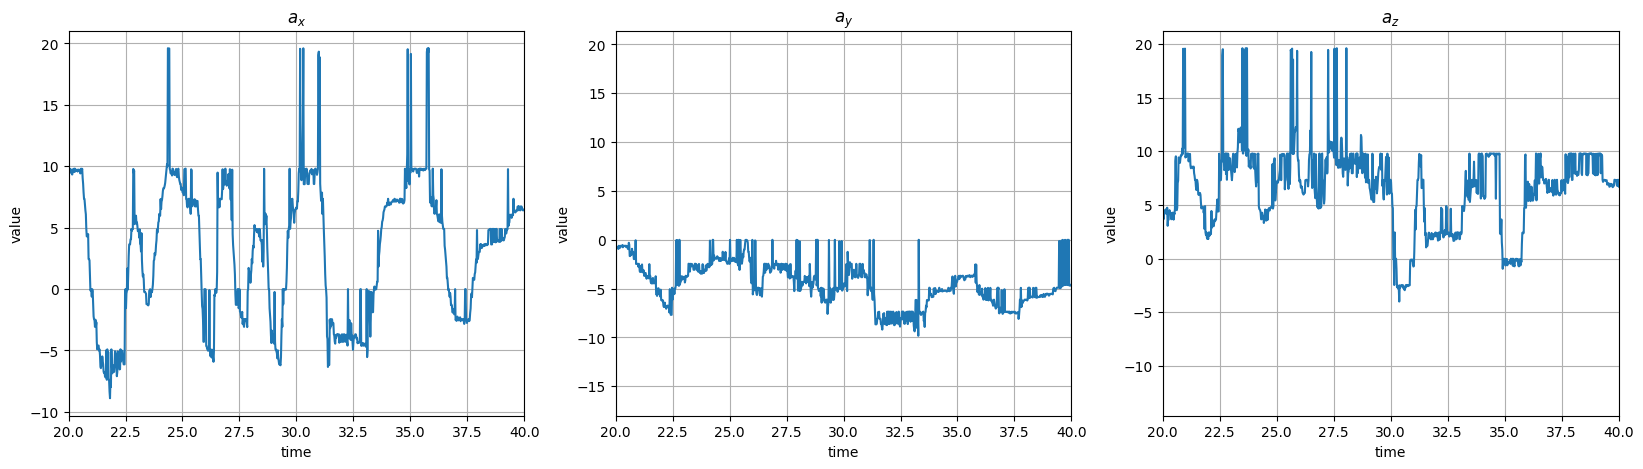

In [9]:
plotData(tData, {
    'a_x': [ax for (ax, ay, az) in aData],
    'a_y': [ay for (ax, ay, az) in aData],
    'a_z': [az for (ax, ay, az) in aData],
}, range=SAMPLE_RANGE)

- Aplicando Filtro Passa Baixa

TransferFunction(array([39.4784176]), array([ 1.        ,  8.88576588, 39.4784176 ]))

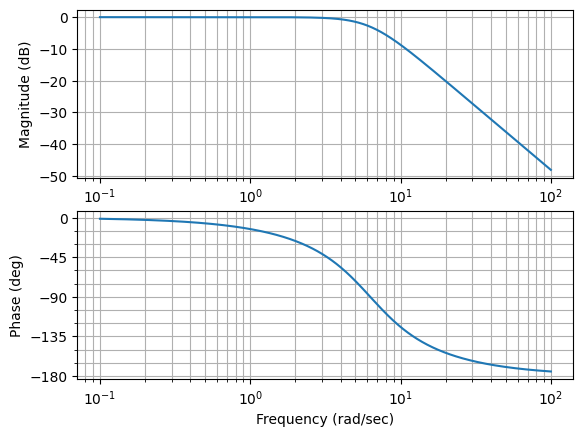

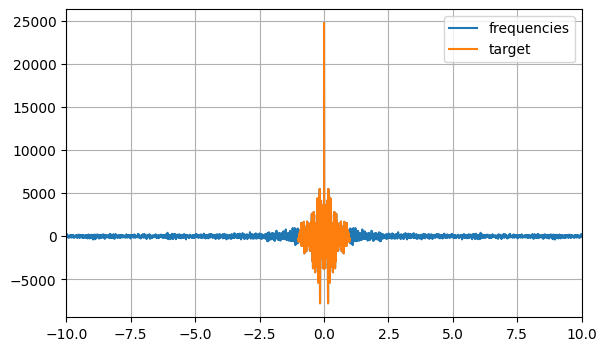

In [10]:
fc = 1.0
filter = LowBandFilter(f_c=fc, dt=dt)
filter.plot()
NumpyFilter().see([ax for (ax, ay, az) in aData], dt, limits=(-fc, fc), range=(-10, 10))

In [11]:
print(filter.getOut() + ';')

Xn*(0.003613) + Xn1*(0.007225) + Xn2*(0.003613) + Yn1*(1.822927) + Yn2*(-0.837377);


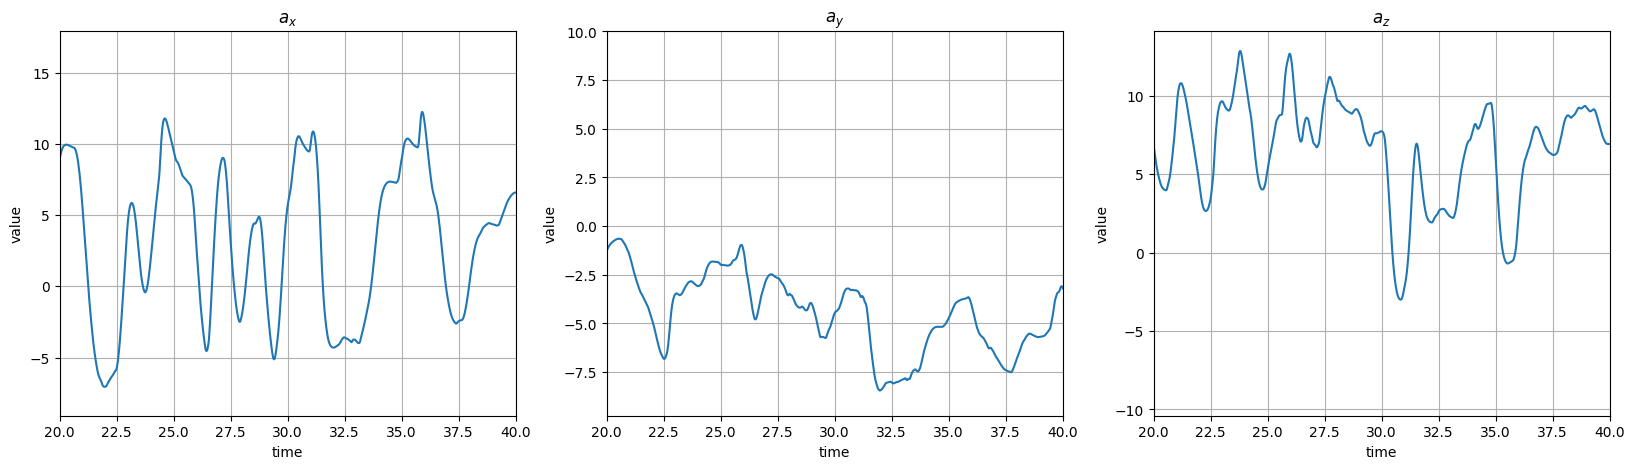

In [12]:
aData = np.column_stack([
    filter.apply([ax for (ax, ay, az) in aData]),
    filter.apply([ay for (ax, ay, az) in aData]),
    filter.apply([az for (ax, ay, az) in aData])
])

plotData(tData, {
    'a_x': [ax for (ax, ay, az) in aData],
    'a_y': [ay for (ax, ay, az) in aData],
    'a_z': [az for (ax, ay, az) in aData],
}, range=SAMPLE_RANGE)

### Velocidade Linear

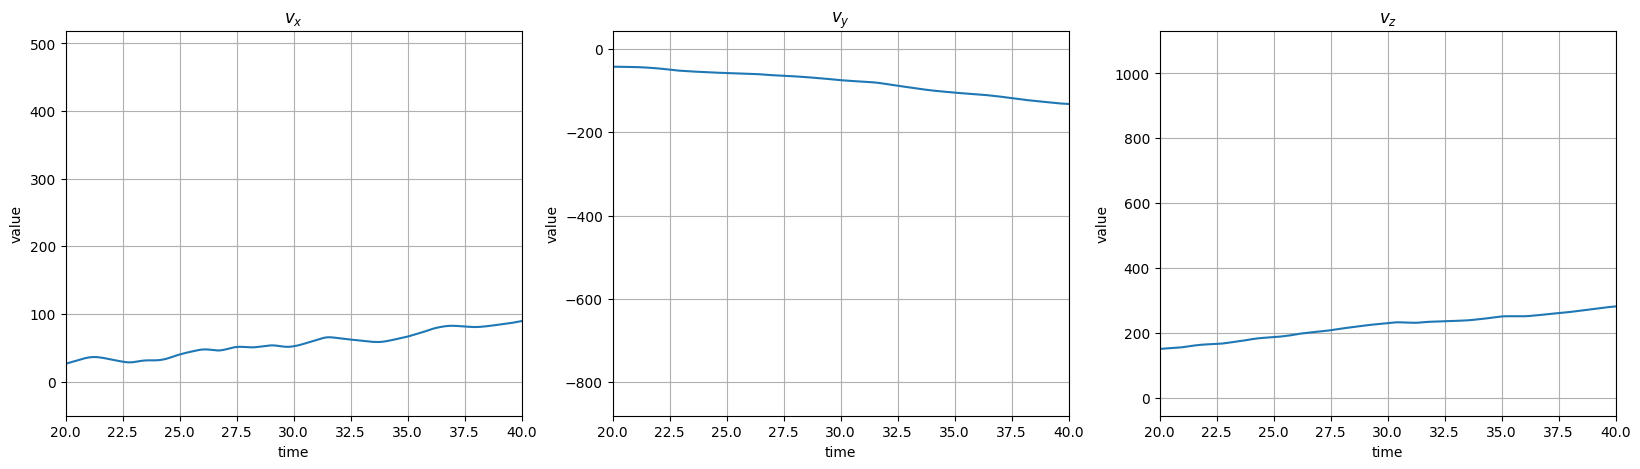

In [13]:
vData = np.column_stack([
    Integral(dt).apply([ax for (ax, ay, az) in aData]),
    Integral(dt).apply([ay for (ax, ay, az) in aData]),
    Integral(dt).apply([az for (ax, ay, az) in aData])
])

plotData(tData, {
    'v_x': [vx for (vx, vy, vz) in vData],
    'v_y': [vy for (vx, vy, vz) in vData],
    'v_z': [vz for (vx, vy, vz) in vData],
}, range=SAMPLE_RANGE)

### Posição Linear

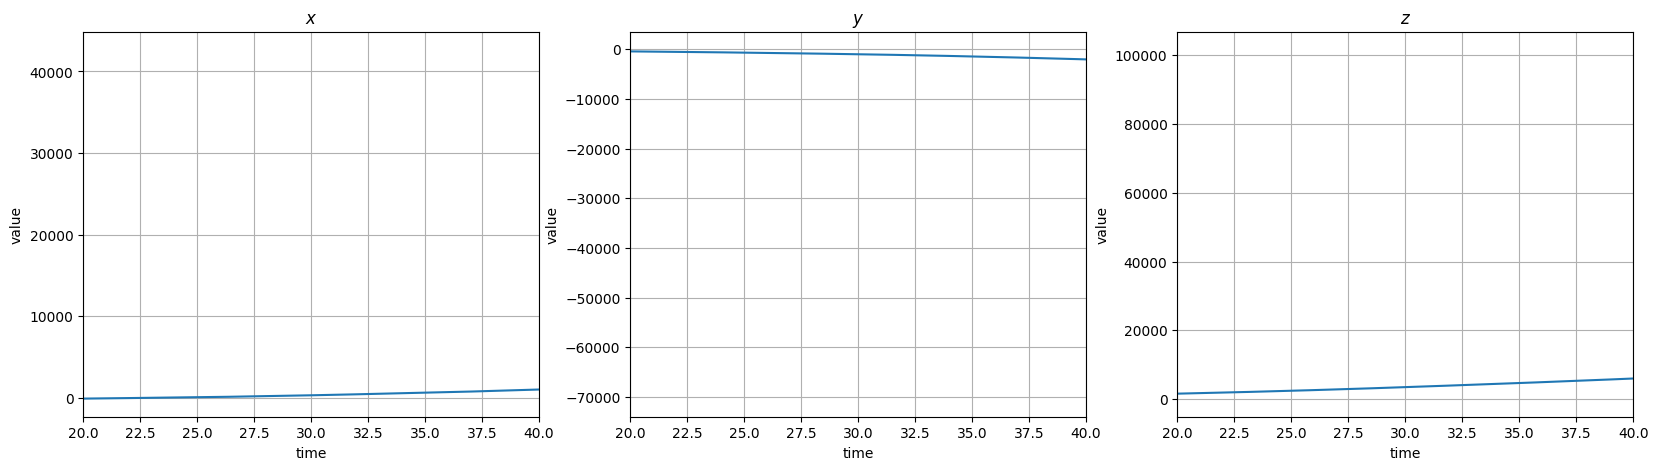

In [14]:
xData = np.column_stack([
    Integral(dt).apply([vx for (vx, vy, vz) in vData]),
    Integral(dt).apply([vy for (vx, vy, vz) in vData]),
    Integral(dt).apply([vz for (vx, vy, vz) in vData])
])

plotData(tData, {
    'x': [x for (x, y, z) in xData],
    'y': [y for (x, y, z) in xData],
    'z': [z for (x, y, z) in xData],
}, range=SAMPLE_RANGE)

# ÂNGULAÇÃO

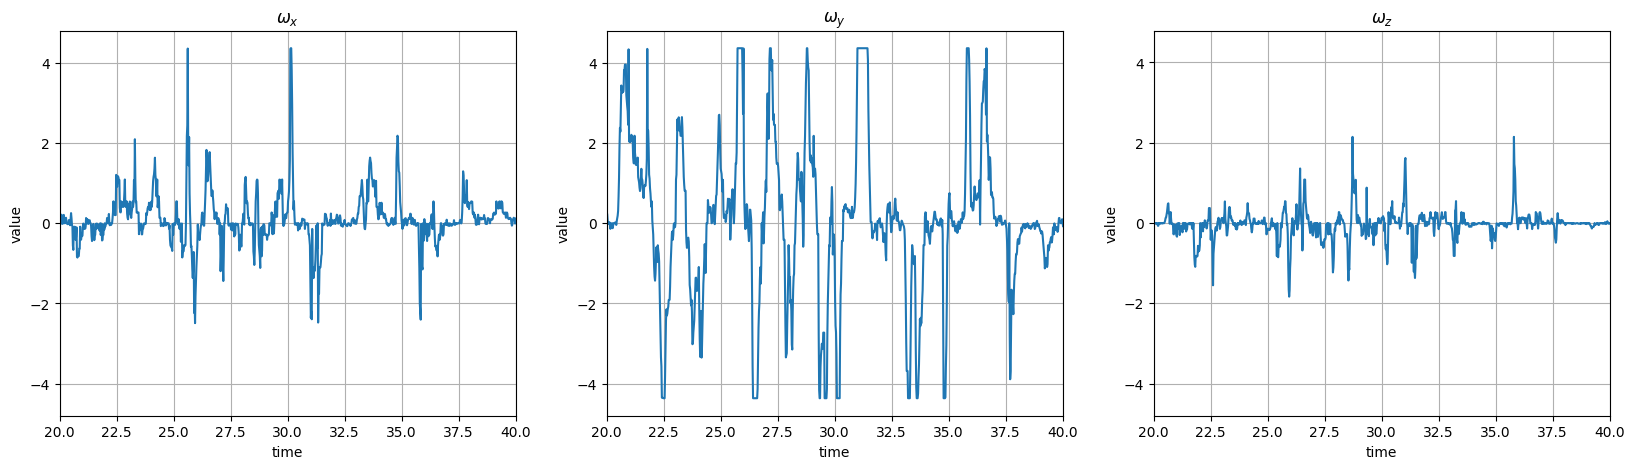

In [15]:
plotData(tData, {
    '\omega_x': [wx for (wx, wy, wz) in wData],
    '\omega_y': [wy for (wx, wy, wz) in wData],
    '\omega_z': [wz for (wx, wy, wz) in wData],
}, range=SAMPLE_RANGE)

- Aplicando Filtro Passa Baixa

TransferFunction(array([39.4784176]), array([ 1.        ,  8.88576588, 39.4784176 ]))

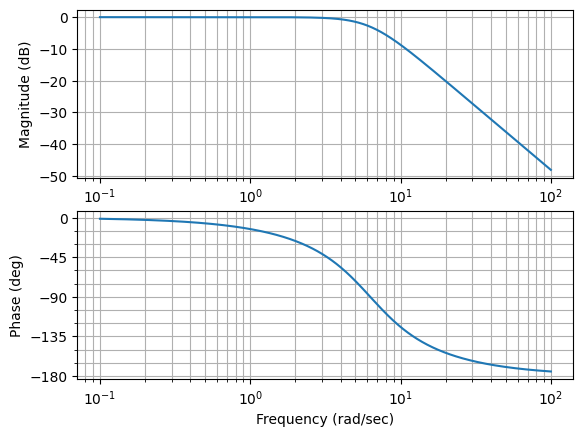

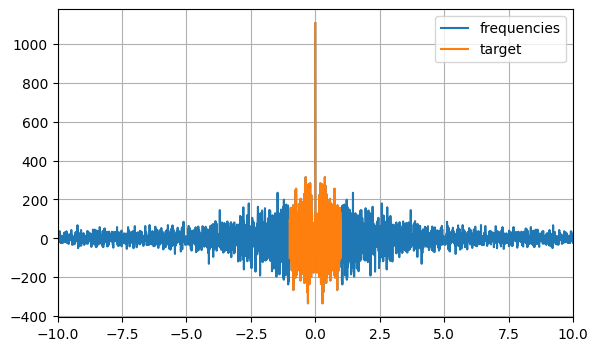

In [16]:
fc = 1.0
filter = LowBandFilter(f_c=fc, dt=dt)
filter.plot()
NumpyFilter().see([wx for (wx, wy, wz) in wData], dt, limits=(-fc, fc), range=(-10, 10))

In [17]:
print(filter.getOut() + ';')

Xn*(0.003613) + Xn1*(0.007225) + Xn2*(0.003613) + Yn1*(1.822927) + Yn2*(-0.837377);


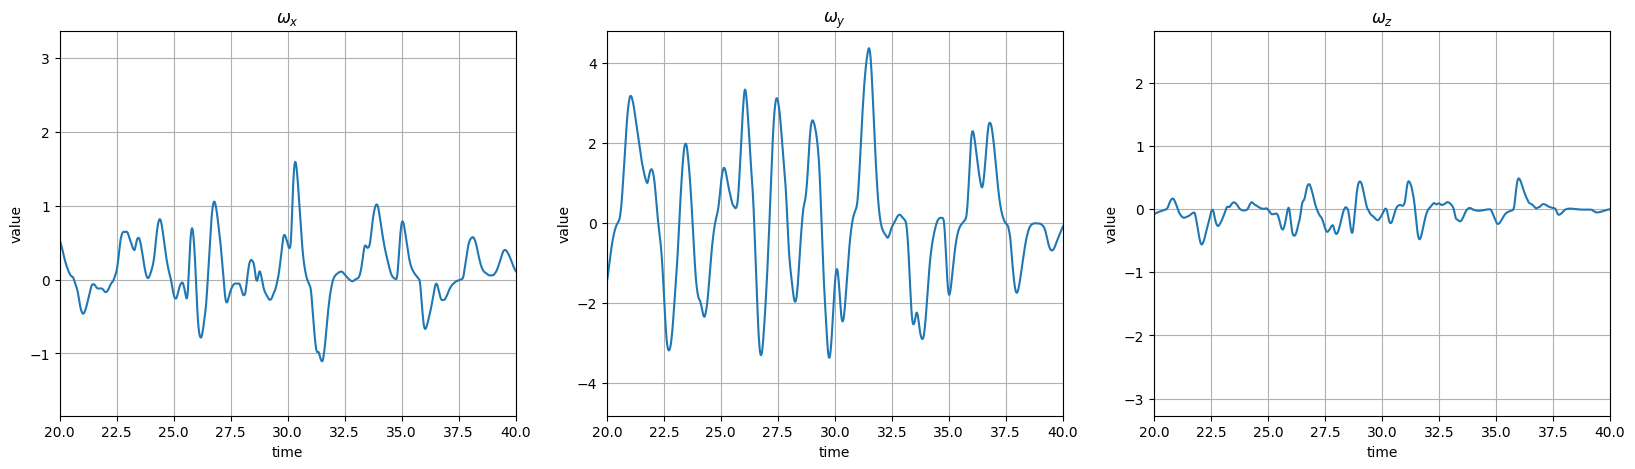

In [18]:
wData = np.column_stack([
    filter.apply([wx for (wx, wy, wz) in wData]),
    filter.apply([wy for (wx, wy, wz) in wData]),
    filter.apply([wz for (wx, wy, wz) in wData])
])

plotData(tData, {
    '\omega_x': [wx for (wx, wy, wz) in wData],
    '\omega_y': [wy for (wx, wy, wz) in wData],
    '\omega_z': [wz for (wx, wy, wz) in wData],
}, range=SAMPLE_RANGE)

### Ângulo (integração)

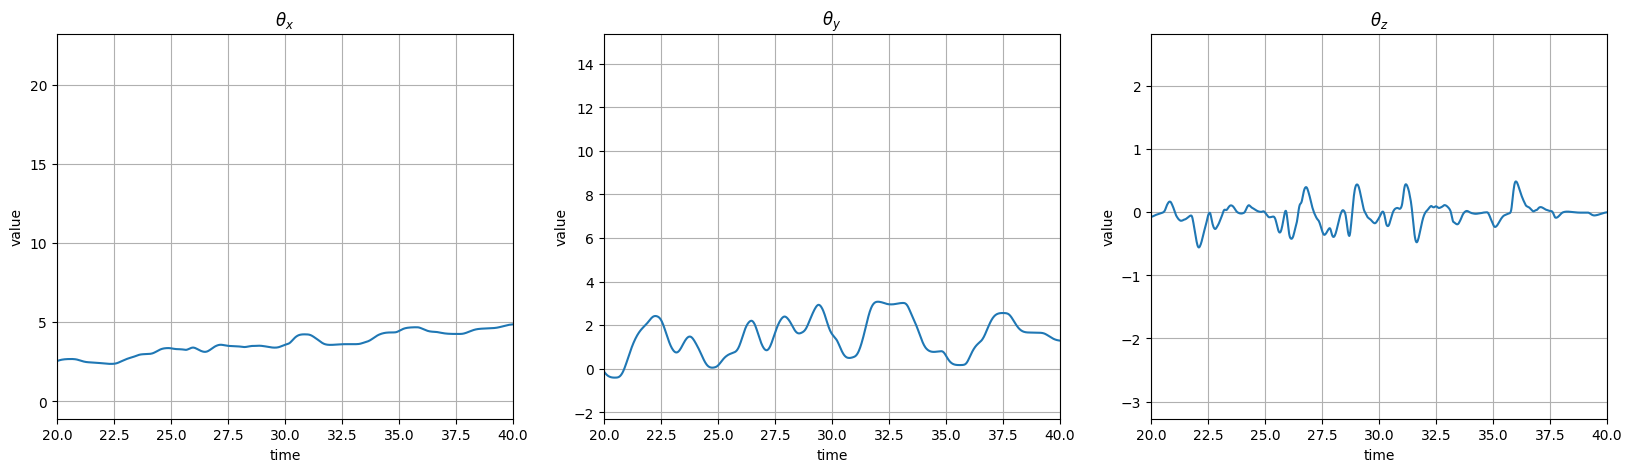

In [19]:
oData = np.column_stack([
    Integral(dt).apply([wx for (wx, wy, wz) in wData]),
    Integral(dt).apply([wy for (wx, wy, wz) in wData]),
    Integral(dt).apply([wz for (wx, wy, wz) in wData])
])

plotData(tData, {
    r'\theta_x': [ox for (ox, oy, oz) in oData],
    r'\theta_y': [oy for (ox, oy, oz) in oData],
    r'\theta_z': [oz for (ox, oy, oz) in wData],
}, range=SAMPLE_RANGE)

### Campo Vetorial

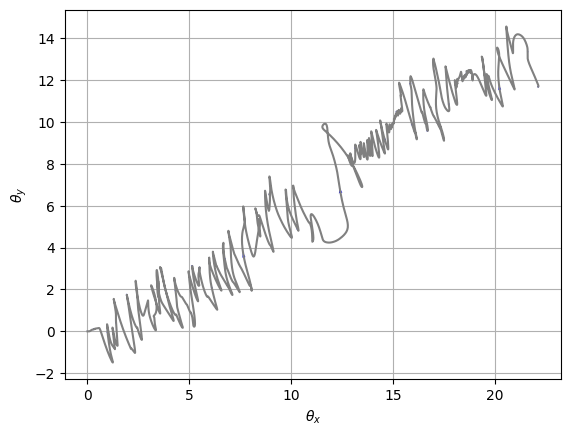

In [20]:
indices = np.linspace(0, len(oData)-1, 40, dtype=int)
x = np.array([ox for (ox, oy, oz) in oData])[indices]
y = np.array([oy for (ox, oy, oz) in oData])[indices]
u = np.array([wx for (wx, wy, wz) in wData])[indices]
v = np.array([wy for (wx, wy, wz) in wData])[indices]

plt.plot([ox for (ox, oy, oz) in oData], [oy for (ox, oy, oz) in oData], color='gray')
plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=15, width=0.004, color='blue')
plt.xlabel(r'$\theta_x$'), plt.ylabel(r'$\theta_y$'), plt.grid()
plt.show()

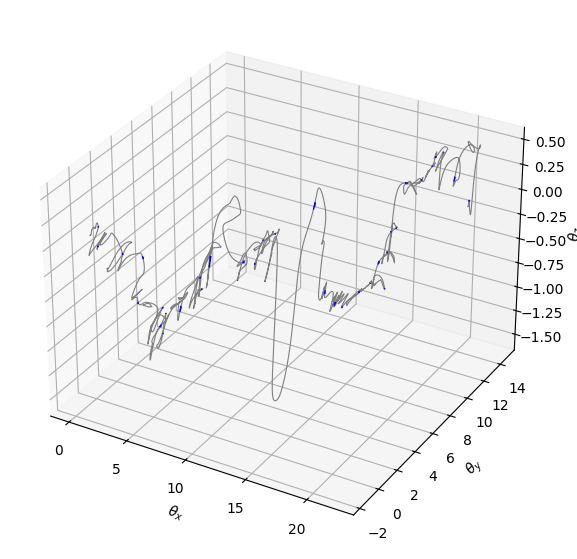

In [21]:
fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(111, projection='3d')
indices = np.linspace(0, len(oData)-1, 50, dtype=int)

x = np.array([ox for (ox, oy, oz) in oData])[indices]
y = np.array([oy for (ox, oy, oz) in oData])[indices]
z = np.array([oz for (ox, oy, oz) in oData])[indices]

u = np.array([wx for (wx, wy, wz) in wData])[indices]
v = np.array([wy for (wx, wy, wz) in wData])[indices]
w = np.array([wz for (wx, wy, wz) in wData])[indices]

plt.plot([ox for (ox, oy, oz) in oData], [oy for (ox, oy, oz) in oData], [oz for (ox, oy, oz) in oData], lw=0.8, color='gray')
ax.quiver(x, y, z, u, v, w, length=0.08, normalize=False, color='blue', linewidth=1)
ax.set_xlabel(r'$\theta_x$'), ax.set_ylabel(r'$\theta_y$'), ax.set_zlabel(r'$\theta_z$')
plt.show()

# ROW, PITCH, YAW

In [22]:
import math

def sign(x):
    return 1 if x >= 0 else -1

class Quaternions:
    def __init__(self):
        self.q = np.array([1.0, 0.0, 0.0, 0.0])
        self.pitch = self.roll = self.yaw = 0

    def product(self, q1, q2):
        w1, x1, y1, z1 = q1.data
        w2, x2, y2, z2 = q2.data

        w = w1*w2 - x1*x2 - y1*y2 - z1*z2
        x = w1*x2 + x1*w2 + y1*z2 - z1*y2
        y = w1*y2 - x1*z2 + y1*w2 + z1*x2
        z = w1*z2 + x1*y2 - y1*x2 + z1*w2
        return np.array([w, x, y, z])
    
    def euler(self, qData):
        q0, q1, q2, q3 = qData.data
        # Roll (x-axis rotation)
        sinr_cosp = 2 * (q0 * q1 + q2 * q3)
        cosr_cosp = 1 - 2 * (q1**2 + q2**2)
        roll = math.atan2(sinr_cosp, cosr_cosp)
        
        # Pich (y-axis rotation)
        sinp  = 2*(q0 * q2 - q3 * q1)
        pitch = sign(sinp)*(math.pi/2) if abs(sinp) >= 1 else math.asin(sinp)

        # Yaw (z-axis rotation)
        siny_cosp = 2 * (q0 * q3 + q1 * q2)
        cosy_cosp = 1 - 2 * (q2**2 + q3**2)
        yaw = math.atan2(siny_cosp, cosy_cosp)
        return (pitch, roll, yaw)

    def fromOmega(self, wx, wy, wz):
        omega = np.array([0.0, wx, wy, wz])
        q_dot = self.product(self.q, omega)
        self.q = q_dot*0.5*dt + self.q
        self.q = self.q / np.linalg.norm(self.q)

    def fromAccel(self, ax, ay, az):
        ax, ay, az = np.array([ax, ay, az]).norm().data
        pitch = math.atan2(-ax, math.sqrt(ay**2 + az**2))
        roll  = math.atan2(ay, az)
        yaw   = 0  # sem magnetômetro
        
        qroll  = np.array([math.cos(roll/2),  math.sin(roll/2), 0, 0])
        qpitch = np.array([math.cos(pitch/2), 0, math.sin(pitch/2), 0])
        qyaw   = np.array([math.cos(yaw/2),   0, 0, math.sin(yaw/2)])

        #q = q_yaw ⊗ (q_pitch ⊗ q_roll)
        q_temp = self.product(qpitch, qroll)
        return self.product(qyaw, q_temp)
    
    def update(self, ax, ay, az, wx, wy, wz):    
        self.fromOmega(wx, wy, wz)
        #self.fromAccel(ax, ay, az)
        self.pitch, self.roll, self.yaw = self.euler(self.q)


q = Quaternions()

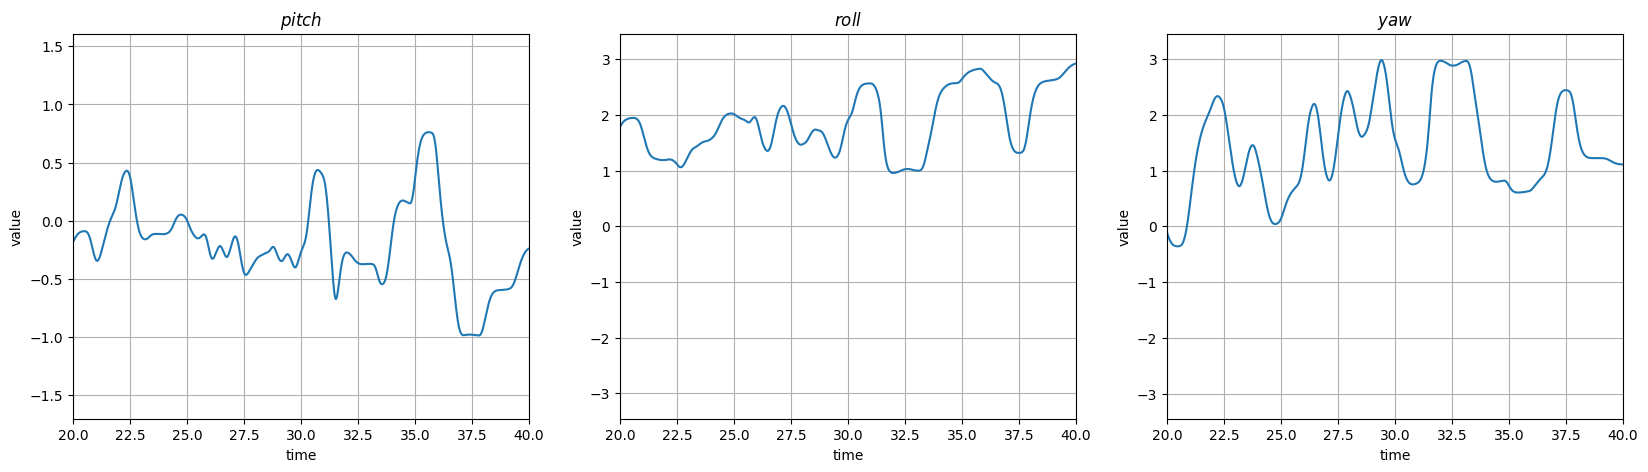

In [23]:
eulerData = []

for a, w in zip(aData, wData):
    ax, ay, az = a 
    wx, wy, wz = w 
    q.update(ax, ay, az, wx, wy, wz)
    eulerData.append([q.pitch, q.roll, q.yaw])


plotData(tData, {
    r'pitch': [pitch for (pitch, roll, yaw) in eulerData],
    r'roll' : [roll for (pitch, roll, yaw) in eulerData],
    r'yaw'  : [yaw for (pitch, roll, yaw) in eulerData],
}, range=SAMPLE_RANGE)